In [24]:
import pandas as pd

# ----- Function Definitions -----
def harmonize_agrupacion_id(agrupacion_id):
    if pd.isna(agrupacion_id):
        return "000000"
    else:
        try:
            return str(int(float(agrupacion_id))).zfill(6)
        except ValueError:
            return agrupacion_id

In [25]:
# ----- Data Loading -----
df = pd.read_csv('./../datos/BD/votos_eleccion_17_table.csv')
cargo = pd.read_csv('./../datos/BD/cargo_tags.csv')
agrup_lista = pd.read_csv('./../datos/BD/agrupacion_lista_table.csv')
claves_dptos = pd.read_csv('./../datos/BD/claves_dptos_ref.csv')
eleccion_tags = pd.read_csv('./../datos/BD/eleccion_tags.csv')
prov_nams = pd.read_csv('./../datos/BD/distrito_table.csv')



/tmp/ipykernel_379914/915858030.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./../datos/BD/votos_eleccion_17_table.csv')


In [26]:

# ----- Data Preprocessing -----
# Votos Eleccion Data Preprocessing
df = df[df['cargo_id'].isin([1, 3])]
df['agrupacion_id'] = df['agrupacion_id'].apply(harmonize_agrupacion_id)

# Agrup Lista Data Preprocessing
agrup_lista['agrupacion_id'] = agrup_lista['agrupacion_id'].apply(harmonize_agrupacion_id)
agrup_lista['lista_numero'] = agrup_lista['lista_numero'].apply(harmonize_agrupacion_id)

# Claves Dptos Data Preprocessing
claves_dptos = claves_dptos.dropna(subset=['codprov']).astype({'codprov': 'Int64', 'coddepto' : 'Int64', 'IN1' : 'Int64'})
claves_dptos[['codprov', 'coddepto', 'IN1']] = claves_dptos[['codprov', 'coddepto', 'IN1']].astype(str).apply(lambda x: x.str.zfill(x.str.len().max()))
claves_dptos.loc[claves_dptos.seccion_nombre == 'La Plata', 'IN1'] = '06441'





In [27]:
# ----- Data Merging & Transformations -----
# Merge with simil_nombre
simil_nombre = agrup_lista.groupby(['eleccion_id', 'distrito_id', 'agrupacion_id']).agrupacion_nombre.first().reset_index()
merged_data = df.merge(simil_nombre)

# Harmonize 'agrupacion_nombre'
for old_name, new_name in [('CAMBIEMOS BUENOS AIRES', 'CAMBIEMOS'), ('JUNTOS', 'JUNTOS POR EL CAMBIO')]:
    merged_data['agrupacion_nombre'] = merged_data['agrupacion_nombre'].replace(old_name, new_name)
merged_data['agrupacion_nombre'] = merged_data['agrupacion_nombre'].str.title()

In [28]:
# Group and aggregate data
aggregated_data = merged_data.groupby(['eleccion_id', 'cargo_id', 'agrupacion_nombre', 'lista_numero', 'votos_tipo']).agg({'votos_cantidad': 'sum'}).reset_index()

# Top N aggregation
N = 8
top_aggregated_data = aggregated_data.groupby(['eleccion_id', 'cargo_id', 'votos_tipo']).apply(lambda x: x.nlargest(N, 'votos_cantidad')).reset_index(drop=True).rename(columns={'votos_cantidad': 'votos_nacional'})

# Further transformations...
data_copy = df.copy()
for old_name, new_name in [('CAMBIEMOS BUENOS AIRES', 'CAMBIEMOS'), ('JUNTOS', 'JUNTOS POR EL CAMBIO')]:
    data_copy['agrupacion_nombre'] = data_copy['agrupacion_nombre'].replace(old_name, new_name)
data_copy['agrupacion_nombre'] = data_copy['agrupacion_nombre'].str.title().str.strip()
data_copy = data_copy.merge(top_aggregated_data, how='left')
data_copy['agrupacion_nombre_'] = data_copy['agrupacion_nombre'].mask(data_copy['votos_nacional'].isnull(), 'Resto')
data_aggregated = data_copy.groupby(['distrito_id', 'seccion_id', 'circuito_id', 'mesa_id', 'cargo_id', 'agrupacion_nombre_', 'lista_numero', 'votos_tipo', 'eleccion_id']).agg({'votos_cantidad': 'sum'}).reset_index()


In [29]:


# More transformations...
data_circ = data_aggregated.groupby(['eleccion_id', 'cargo_id', 'agrupacion_nombre_', 'lista_numero', 'votos_tipo', 'distrito_id', 'seccion_id', 'circuito_id'])[['votos_cantidad']].sum()
data_circ = data_circ.reset_index()
# data_circ.to_csv('./../datos/out/votos_agrup_circ.csv')

# data_circ
# data_circ = pd.read_csv('./../datos/out/votos_agrup_circ.csv')

data_circ = data_circ.merge(eleccion_tags).merge(cargo)


# Group by 'eleccion_tag', 'cargo_tag', and 'in1_prov', and calculate the sum of 'votos_cantidad', divide for PCT
sum_votes = data_circ.groupby(['eleccion_tag', 'cargo_tag', 'distrito_id', 'seccion_id', 'votos_tipo', 'circuito_id'])['votos_cantidad'].transform('sum')
data_circ['votos_porcentaje'] = data_circ['votos_cantidad'] / sum_votes
data_circ.reset_index(drop = True).to_csv('./../datos/out/votos_agrup_lista_circ.csv', index = False)

data_circ_ix = data_circ.set_index(['distrito_id', 'seccion_id', 'circuito_id', 'eleccion_tag', 'cargo_tag', 'agrupacion_nombre_', 'lista_numero', 'votos_tipo'])


data_circ_table_cnt = data_circ_ix['votos_cantidad'].unstack(['eleccion_tag', 'cargo_tag', 'votos_tipo', 'agrupacion_nombre_', 'lista_numero'])
data_circ_table_pct = data_circ_ix['votos_porcentaje'].unstack(['eleccion_tag', 'cargo_tag', 'votos_tipo', 'agrupacion_nombre_', 'lista_numero'])

# # ----- Exporting -----
# data_circ_geoms_cnt.to_file('./../datos/geojson/votos_cnt_circ.geojson', driver='GeoJSON')
# data_circ_geoms_pct.to_file('./../datos/geojson/votos_pct_circ.geojson', driver='GeoJSON')


## Datos Pobreza

In [40]:
import pandas as pd
import numpy as np

# Load data
print("Loading data...")
df_files = [
    './../../indice-pobreza-UBA/data/Pobreza/personas_ingresos_f0.05_2022-11-15_ARG.csv',
    './../../indice-pobreza-UBA/data/Pobreza/personas_ingresos_f0.05_2023-02-15_ARG.csv',
    './../../indice-pobreza-UBA/data/Pobreza/personas_ingresos_f0.05_2022-05-15_ARG.csv',
    './../../indice-pobreza-UBA/data/Pobreza/personas_ingresos_f0.05_2022-08-15_ARG.csv'
]
df = pd.concat([pd.read_csv(file) for file in df_files])

# Process data
print("Processing data...")
df['ingresos'] = 25 * (np.power(10, df['P47T_persona']) - 1)
df['ingresos'] = df['ingresos'].round(-3).astype(int)

# Load and combine geo data
print("Loading and combining geo data...")
geo_files = [
    './../../indice-pobreza-UBA/data/Pobreza/hogares_geo_f0.05_2022_ARG.csv',
    './../../indice-pobreza-UBA/data/Pobreza/hogares_geo_f0.05_2023_ARG.csv'
]
geo = pd.concat([pd.read_csv(file) for file in geo_files])
hogar_circuito = geo[['HOGAR_REF_ID', 'distrito_id', 'seccion_id', 'seccion_nombre', 'circuito']].drop_duplicates()

# Merge data
print("Merging data...")
persona_circuito = df.merge(hogar_circuito)

# Aggregation
print("Aggregating data...")
ingreso_medio = persona_circuito.groupby(['distrito_id', 'seccion_id', 'seccion_nombre', 'circuito']).agg({'ingresos': 'median'}).reset_index()
ingreso_medio['circuito_id'] = ingreso_medio['circuito'].astype(str).str.zfill(6)
ingreso_medio.drop('circuito', axis=1, inplace=True)
ingreso_medio[['distrito_id', 'seccion_id']] = ingreso_medio[['distrito_id', 'seccion_id']].astype('int64')

print("Done!")


Loading data...
Processing data...
Loading and combining geo data...


/tmp/ipykernel_379914/2434992763.py:25: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  geo = pd.concat([pd.read_csv(file) for file in geo_files])
/tmp/ipykernel_379914/2434992763.py:25: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  geo = pd.concat([pd.read_csv(file) for file in geo_files])


Merging data...
Aggregating data...
Done!


In [41]:
ingreso_medio.head()

distrito_id  seccion_id seccion_nombre  ingresos circuito_id
0            1           1      Comuna 01  175000.0      000001
1            1           1      Comuna 01  167000.0      000002
2            1           1      Comuna 01   90000.0      000003
3            1           1      Comuna 01  203000.0      000004
4            1           1      Comuna 01   58000.0      000005

In [39]:
ingreso_medio.to_csv('./ingreso_medio.csv', index=False)

## Unir Ingresos con votos

### Tamanos de circuitos

In [ ]:
votos = data_circ_table_cnt['PASO23n']['PR'].sum().sort_values(ascending = False)
votos

votos_tipo  agrupacion_nombre_                              lista_numero
POSITIVO    La Libertad Avanza                              3016            7116352.0
            Union Por La Patria                             3005            5070104.0
            Juntos Por El Cambio                            3008            4022466.0
                                                            3007            2675563.0
            Union Por La Patria                             3006            1390585.0
BLANCO      Resto                                           0               1148342.0
POSITIVO    Hacemos Por Nuestro Pais                        3001             907437.0
            Frente De Izquierda Y De Trabajadores - Unidad  3009             442085.0
NULO        Resto                                           0                293041.0
POSITIVO    Frente De Izquierda Y De Trabajadores - Unidad  3010             186808.0
            Resto                                           3011   

<Axes: >

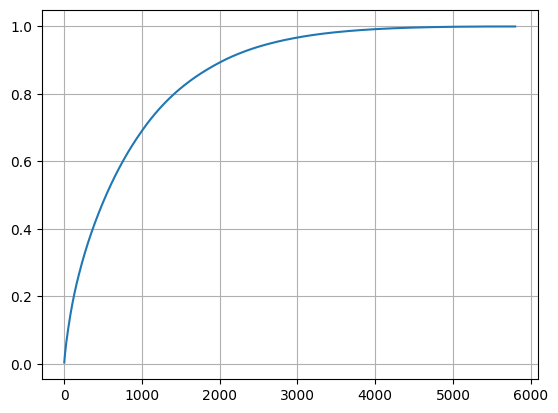

In [ ]:
votos_circuito = data_circ_table_cnt['PASO23n']['PR'].sum(1).sort_values(ascending=False)

s = votos_circuito.reset_index(drop = True)
(s/s.sum()).cumsum().plot(grid = True)

In [ ]:
## Tomar los 3000 circuitos grandes, es decir, los que tienen mas de 1000 votos.
votos_circuito.head(3000)

distrito_id  seccion_id  circuito_id
2            77          00652A         89545.0
             61          00635B         73840.0
             80          000665         72313.0
             38          000302         71046.0
             61          000635         67004.0
                                         ...   
             107         000907          1007.0
22           12          000103          1005.0
7            14          00084A          1005.0
8            9           000164          1002.0
4            26          000402          1001.0
Length: 3000, dtype: float64

In [ ]:
circuitos_ppales = votos_circuito.loc[votos_circuito > 1000]
circuitos_ppales = circuitos_ppales.index.to_frame().reset_index(drop=True)

### Tamanos de listas

In [ ]:
votos_lista = data_circ.loc[data_circ.cargo_id == 1].groupby(['votos_tipo', 'agrupacion_nombre_', 'lista_numero'])['votos_cantidad'].sum()
votos_lista = votos_lista.sort_values(ascending=False)
main_listas  = votos_lista.head(8)
# s = votos_lista.reset_index(drop = True)
# (s/s.sum()).cumsum().plot(grid = True)
# (s/s.sum()).cumsum()

In [ ]:
# main_listas

In [ ]:
# main_listas = info_table['votos_cantidad'].sum().sort_values(ascending=False).head(10)
main_listas = main_listas.index.to_frame().reset_index(drop=True)
main_listas


votos_tipo                              agrupacion_nombre_  lista_numero
0   POSITIVO                              La Libertad Avanza          3016
1   POSITIVO                             Union Por La Patria          3005
2   POSITIVO                            Juntos Por El Cambio          3008
3   POSITIVO                            Juntos Por El Cambio          3007
4   POSITIVO                             Union Por La Patria          3006
5     BLANCO                                           Resto             0
6   POSITIVO                        Hacemos Por Nuestro Pais          3001
7   POSITIVO  Frente De Izquierda Y De Trabajadores - Unidad          3009

### Merge

In [ ]:
# import geopandas as gpd
# circs_ref = gpd.read_file('./../datos/geojson/circs_ref.geojson')


In [ ]:
# radio_region.COD_2010.unique()

In [ ]:
# radios_circuitos_secciones.COD_2010.unique()

In [ ]:
radio_region = pd.read_csv('./../datos/info/radio_ref.csv', usecols = ['radio', 'NOMDPTO', 'Region'])
radio_region['COD_2010'] = radio_region['radio'].astype(str).str.zfill(9)
radios_circuitos_secciones = pd.read_csv('./../datos/info/radios_circuitos_secciones_ref.csv')[['COD_2010', 'distrito_id', 'seccion_id', 'seccion_nombre']]

merge = radios_circuitos_secciones.merge(radio_region, on = 'COD_2010', how = 'left')

seccion_region = merge.drop(['COD_2010', 'radio'], axis = 1).drop_duplicates()
seccion_region = seccion_region.groupby(['distrito_id', 'seccion_id', 'seccion_nombre']).first()
seccion_region = seccion_region.reset_index()
seccion_region


distrito_id  seccion_id  seccion_nombre         NOMDPTO  \
0              1           1       Comuna 01       Comuna 01   
1              1           2       Comuna 02       Comuna 02   
2              1           3       Comuna 03       Comuna 03   
3              1           4       Comuna 04       Comuna 04   
4              1           5       Comuna 05       Comuna 05   
..           ...         ...             ...             ...   
520           23          15     Yerba Buena     Yerba Buena   
521           23          16      Tafí Viejo      Tafí Viejo   
522           23          17  Tafí Del Valle  Tafí del Valle   
523           24           1         Ushuaia         Ushuaia   
524           24           2      Río Grande      Río Grande   

                Region  
0    Gran Buenos Aires  
1    Gran Buenos Aires  
2    Gran Buenos Aires  
3    Gran Buenos Aires  
4    Gran Buenos Aires  
..                 ...  
520           Noroeste  
521           Noroeste  
522           Noroeste  
523         Patagónica  
524         Patagónica  

[525 rows x 5 columns]

In [ ]:
# df = pd.read_csv('./../datos/info/DPTO_PROV_Region.csv')
# df#.PROV.unique()

In [ ]:
# df = pd.read_csv('./../datos/info/radio_ref.csv')
# prov_region = df[['PROV_REF_ID', 'NOMPROV', 'Region']].drop_duplicates().sort_values(by='PROV_REF_ID')
# prov_region = prov_region.rename(columns = {'PROV_REF_ID': 'distrito_id'})
# # prov_region.groupby()
# # PROV_REF_ID	NOMPROV	Region

In [ ]:
# prov_nams.sort_values('distrito_id')
# # .merge(prov_region)

In [ ]:
info = circuitos_ppales.merge(data_circ.loc[data_circ.cargo_id == 1])
info = main_listas.merge(info)
info = info.merge(prov_nams).merge(seccion_region, how = 'left')
info.head()


votos_tipo  agrupacion_nombre_  lista_numero  distrito_id  seccion_id  \
0   POSITIVO  La Libertad Avanza          3016            2          77   
1   POSITIVO  La Libertad Avanza          3016            2          61   
2   POSITIVO  La Libertad Avanza          3016            2          80   
3   POSITIVO  La Libertad Avanza          3016            2          38   
4   POSITIVO  La Libertad Avanza          3016            2          61   

  circuito_id  eleccion_id  cargo_id  votos_cantidad   año  ... recuento_tipo  \
0      00652A           17         1           22969  2023  ...    PROVISORIO   
1      00635B           17         1           17119  2023  ...    PROVISORIO   
2      000665           17         1           17272  2023  ...    PROVISORIO   
3      000302           17         1           17723  2023  ...    PROVISORIO   
4      000635           17         1           15525  2023  ...    PROVISORIO   

  padron_tipo eleccion_tag cargo_nombre cargo_tag votos_porcentaje  \
0      NORMAL      PASO23n   Presidente        PR         0.281469   
1      NORMAL      PASO23n   Presidente        PR         0.254014   
2      NORMAL      PASO23n   Presidente        PR         0.251885   
3      NORMAL      PASO23n   Presidente        PR         0.267267   
4      NORMAL      PASO23n   Presidente        PR         0.256662   

   distrito_nombre    seccion_nombre           NOMDPTO             Region  
0     Buenos Aires             Merlo             Merlo  Gran Buenos Aires  
1     Buenos Aires        La Matanza        La Matanza  Gran Buenos Aires  
2     Buenos Aires             Morón             Morón  Gran Buenos Aires  
3     Buenos Aires  Florencio Varela  Florencio Varela  Gran Buenos Aires  
4     Buenos Aires        La Matanza        La Matanza  Gran Buenos Aires  

[5 rows x 21 columns]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Create a dictionary of colors for 'agrupacion_nombre_'
colors_dict = {
    'La Libertad Avanza': '#FF00FF',  # Magenta
    'Union Por La Patria': '#00FFFF', # Cyan
    'Juntos Por El Cambio': '#FFFF00' # Yellow
}    # ... add other agrupacion_nombre_ colors here ...



In [ ]:
# info_plot.sort_values(by='votos_porcentaje', ascending=True).reset_index(drop = True)['votos_cantidad'].cumsum().plot()

# Line2D
from matplotlib.lines import Line2D


def weighted_quantile(values, quantiles, sample_weight=None, values_sorted=False):
    """Compute the weighted quantiles of a 1D numpy array."""
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), 'quantiles should be in [0, 1]'
    
    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]
    
    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    weighted_quantiles /= np.sum(sample_weight)
    
    return np.interp(quantiles, weighted_quantiles, values)
import matplotlib.pyplot as plt

def plot_scatter(fig, ax1, info, votos_tipo, agrupacion_nombre_, lista_numero, ingreso_medio, colors_dict, shade=False, alpha=0.5):
    info_plot = info.loc[(info.votos_tipo == votos_tipo) 
                         & (info['agrupacion_nombre_'] == agrupacion_nombre_) 
                         & (info['lista_numero'] == lista_numero)][['distrito_id', 'distrito_nombre', 'circuito_id', 'votos_cantidad', 'votos_porcentaje']]
    info_plot = info_plot.merge(ingreso_medio)

    color = 'gray' if shade else colors_dict.get(agrupacion_nombre_, 'black')

    scatter_plot = ax1.scatter(info_plot['ingresos'], 
               info_plot['votos_porcentaje'] * 100, 
               s=info_plot['votos_cantidad'] / 60,
               c=color,
               alpha=alpha, 
               edgecolors="w", 
               linewidth=0.5)

    ax1.set_xlabel('Ingreso mediano en el CIRCUITO (AR$)')
    ax1.set_ylabel('Votos Porcentaje (%)')
    ax1.set_xlim(0, 200000)
    ax1.set_ylim(0, 60)
    ax1.set_title(f'Agrupación: {agrupacion_nombre_}', fontsize = 10)
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Format the x-axis in engineering notation
    ax1.xaxis.set_major_formatter(lambda x, _: f'{x*1e-3:.0f}k')

    return scatter_plot  # Return scatter plot object for legend


def plot_weighted_box(fig, ax, info, votos_tipo, agrupacion_nombre_, lista_numero, ingreso_medio, bins=np.arange(10000, 200000, 20000)):
    info_plot = info.loc[(info.votos_tipo == votos_tipo) 
                         & (info['agrupacion_nombre_'] == agrupacion_nombre_) 
                         & (info['lista_numero'] == lista_numero)][['distrito_id', 'distrito_nombre', 'circuito_id', 'votos_cantidad', 'votos_porcentaje']]
    info_plot = info_plot.merge(ingreso_medio)
    info_plot_sorted = info_plot.sort_values(by='votos_porcentaje', ascending=True).reset_index(drop=True)
    info_plot_sorted['x_bins'] = pd.cut(info_plot_sorted.ingresos, bins=bins, labels=False)

    grouped = info_plot_sorted.groupby('x_bins')
    q1_list, q2_list, q3_list, bin_means = [], [], [], []

    for bin_num, group in grouped:
        q1_val = weighted_quantile(group.votos_porcentaje, 0.25, sample_weight=group.votos_cantidad)
        q2_val = weighted_quantile(group.votos_porcentaje, 0.5, sample_weight=group.votos_cantidad)
        q3_val = weighted_quantile(group.votos_porcentaje, 0.75, sample_weight=group.votos_cantidad)
        q1_list.append(q1_val)
        q2_list.append(q2_val)
        q3_list.append(q3_val)
        bin_means.append(group.ingresos.mean())  # Calculate mean of the bin for x-axis positioning

    for x, (q1, q2, q3) in zip(bin_means, zip(q1_list, q2_list, q3_list)):
        q1, q2, q3 = q1*100, q2*100, q3*100  # Convert to percentages
        ax.plot([x, x], [q1, q3], color='.3', linewidth=1.5, alpha = .5)
        ax.plot([x-0.2*10000, x+0.2*10000], [q1, q1], color='.3', linewidth=1.5, alpha = .5)
        ax.plot([x-0.2*10000, x+0.2*10000], [q3, q3], color='.3', linewidth=1.5, alpha = .5)
        ax.plot(x, q2, 'k*', alpha = .5)
    # We will rely on the scatter plot's X-axis labeling for income
    ax.set_xlabel('Ingreso mediano en el CIRCUITO (AR$)')
    ax.set_ylabel('Votos Porcentaje (%)')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, axis='y')
    # Format the x-axis in engineering notation
    ax.xaxis.set_major_formatter(lambda x, _: f'{x*1e-3:.0f}k')


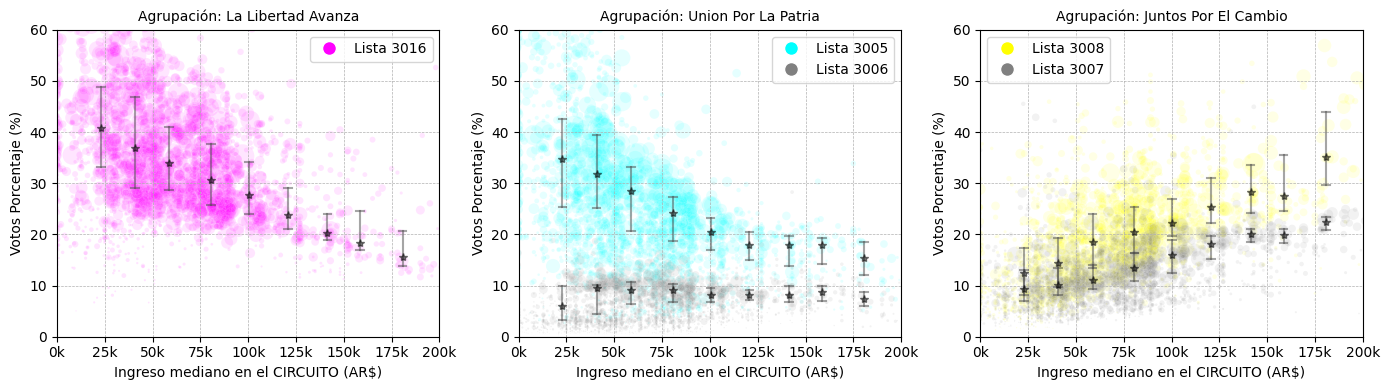

In [ ]:


# Create a new figure with 1 row and 3 columns for the subplots
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

for ax, agrupacion in zip(axs, main_listas['agrupacion_nombre_'].unique()):
    if agrupacion in colors_dict:
        rows_for_agrupacion = main_listas[main_listas['agrupacion_nombre_'] == agrupacion]
        
        legend_elements = []  # To collect legend handles and labels
        for idx, row in enumerate(rows_for_agrupacion.iterrows()):
            _, row = row
            should_shade = idx == 1
            plot_weighted_box(fig, ax, info, row['votos_tipo'], agrupacion, row['lista_numero'], ingreso_medio, bins=np.arange(10000, 200000, 20000))
            
            scatter_plot = plot_scatter(fig, ax, info, row['votos_tipo'], agrupacion, row['lista_numero'], ingreso_medio, colors_dict, shade=should_shade, alpha=0.1)
            color = 'gray' if should_shade else colors_dict.get(agrupacion, 'black')
            legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f"Lista {row['lista_numero']}"))

        # Add legend to ax after all plots are drawn
        ax.legend(handles=legend_elements)

# Adjust layout
plt.tight_layout()
# create if not exists
# import 
from pathlib import Path
Path('images').mkdir(parents=True, exist_ok=True)
# Save figure
plt.savefig('images/votos_vs_ingresosPASO23.jpg')
plt.show()


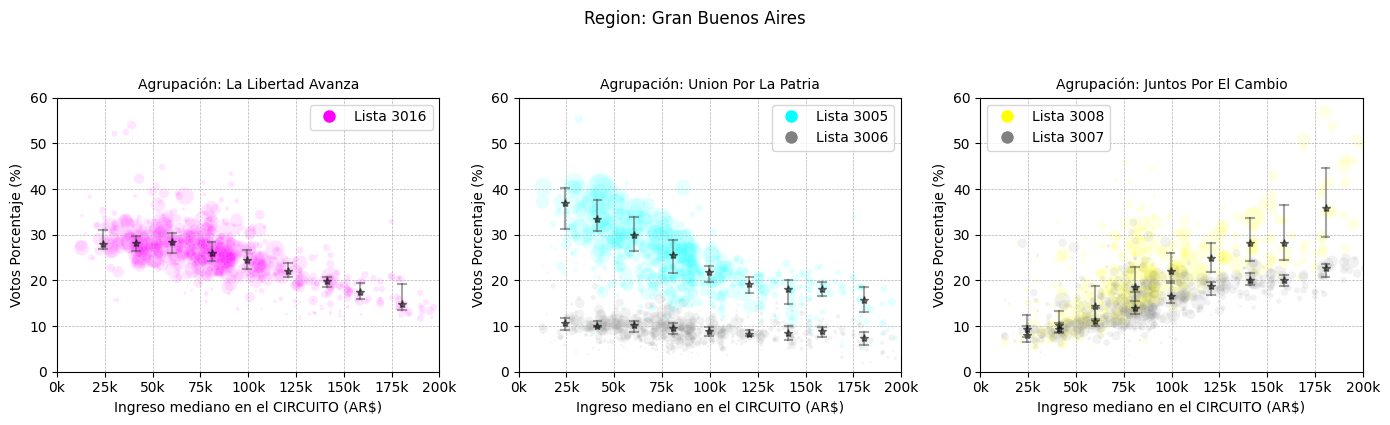

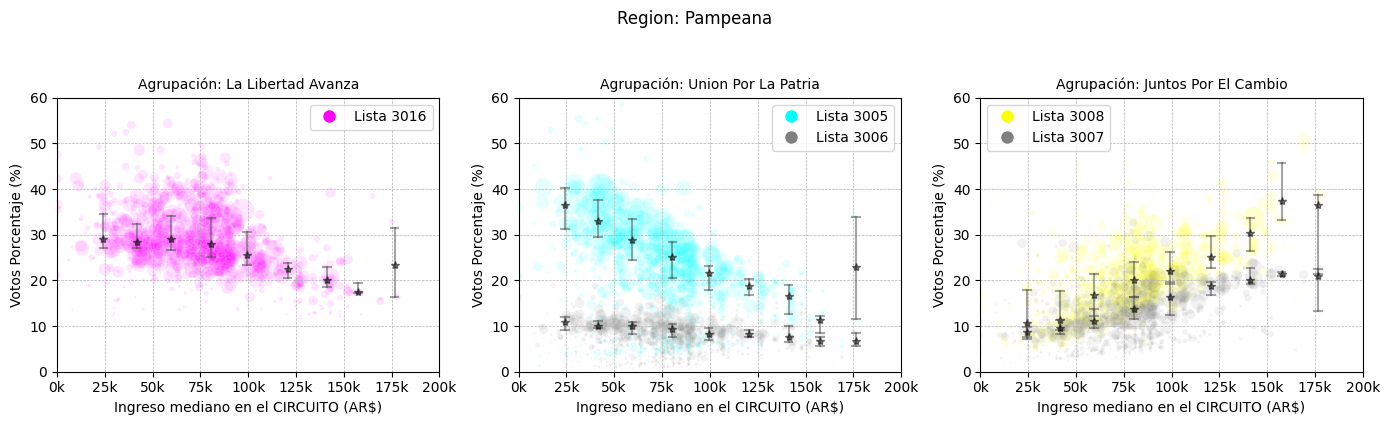

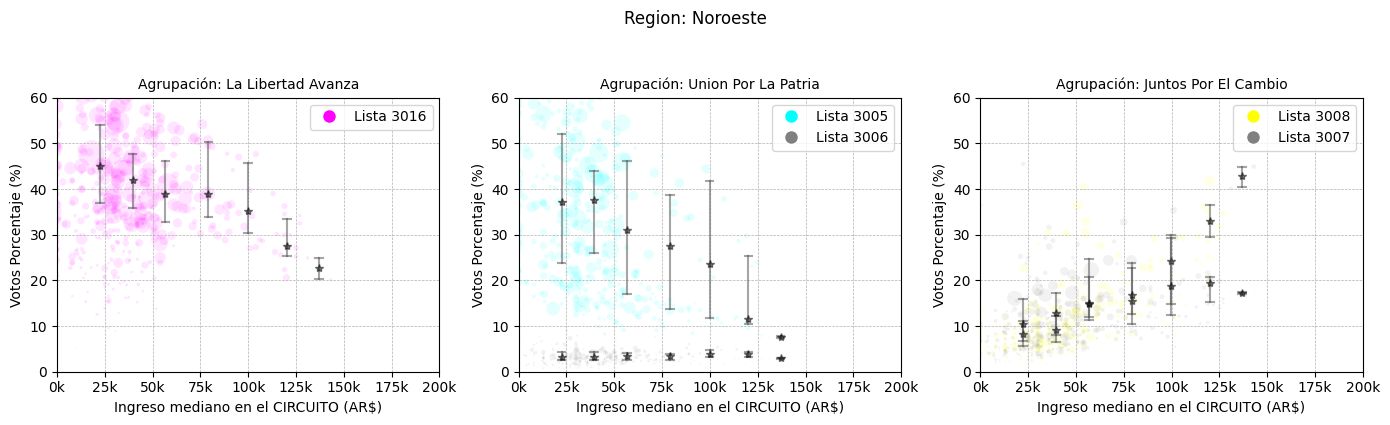

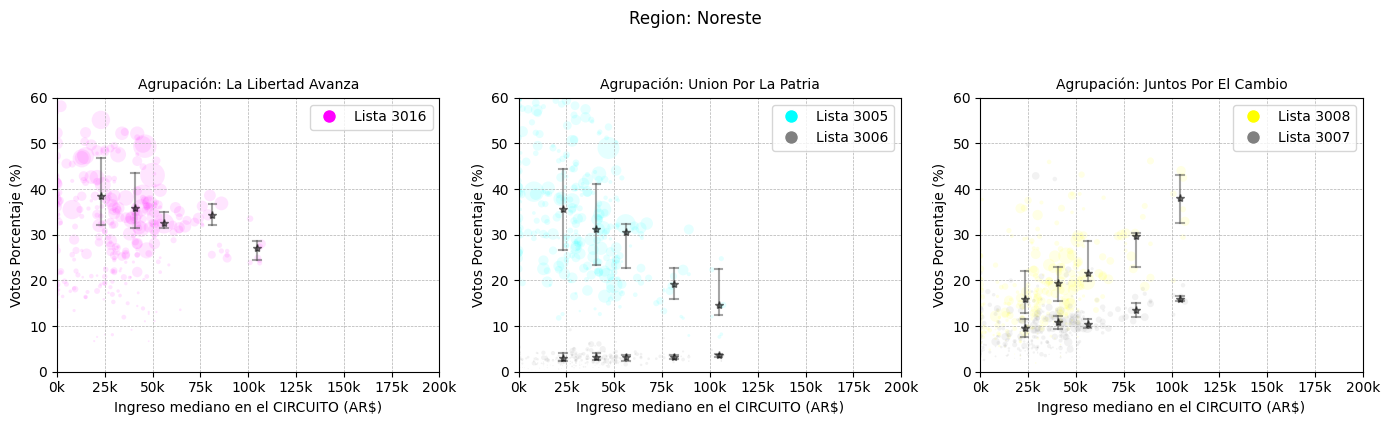

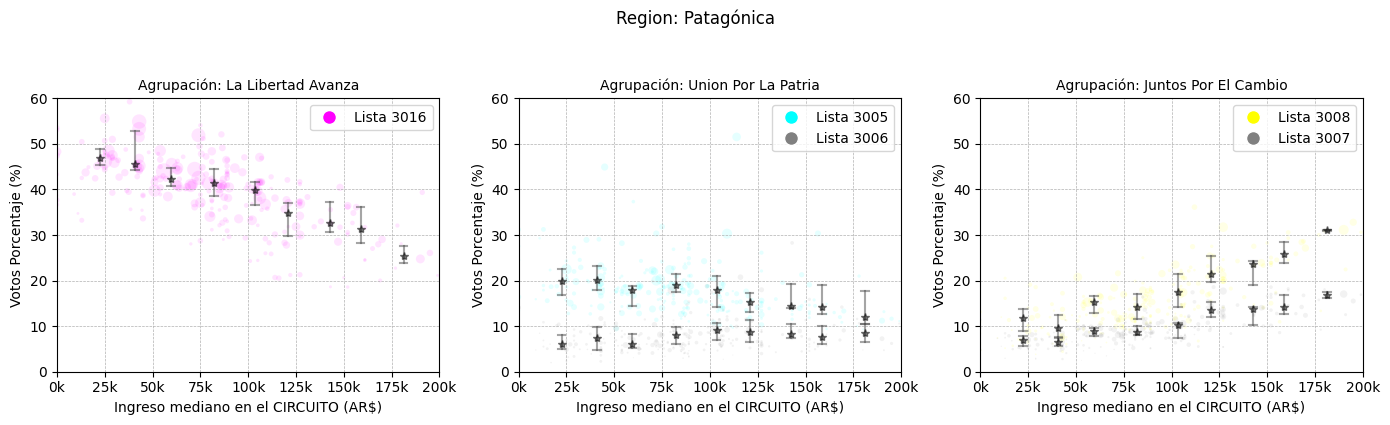

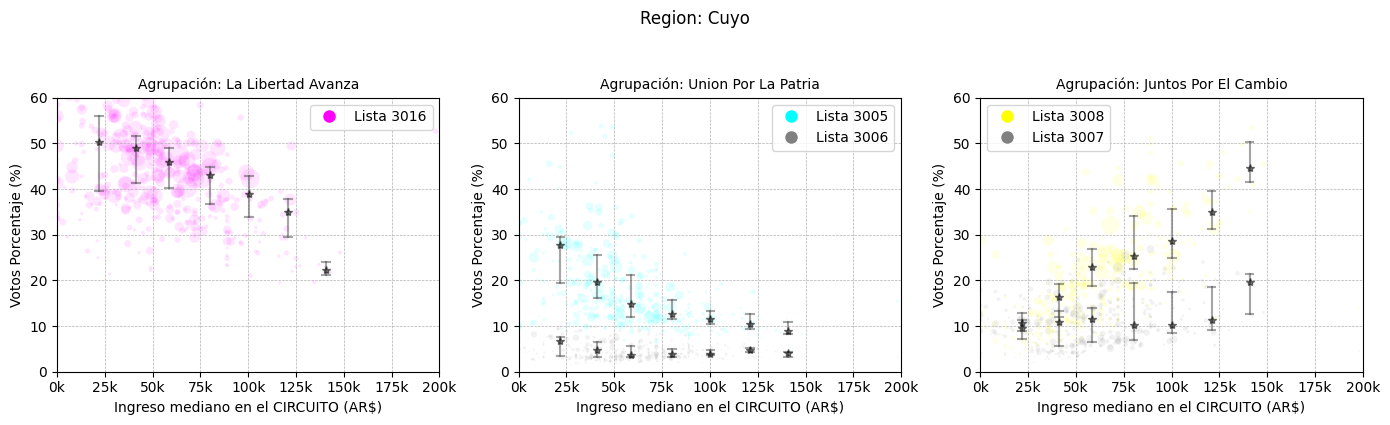

In [ ]:
# Extract unique regions
unique_regions = seccion_region.drop_duplicates(subset=['Region'])['Region']

# Loop over each unique region
for region in unique_regions:
    
    # Filter the data for the current region
    region_ids = seccion_region[seccion_region['Region'] == region]['distrito_id'].unique()
    filtered_info = info[info['distrito_id'].isin(region_ids)]

    # Create a new figure with 1 row and 3 columns for the subplots
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    
    # Loop over each agrupacion within the filtered data
    for ax, agrupacion in zip(axs, main_listas['agrupacion_nombre_'].unique()):
        if agrupacion in colors_dict:
            rows_for_agrupacion = main_listas[main_listas['agrupacion_nombre_'] == agrupacion]
            
            legend_elements = []  # To collect legend handles and labels
            for idx, row in enumerate(rows_for_agrupacion.iterrows()):
                _, row = row
                should_shade = idx == 1
                plot_weighted_box(fig, ax, filtered_info, row['votos_tipo'], agrupacion, row['lista_numero'], ingreso_medio, bins=np.arange(10000, 200000, 20000))
                
                scatter_plot = plot_scatter(fig, ax, filtered_info, row['votos_tipo'], agrupacion, row['lista_numero'], ingreso_medio, colors_dict, shade=should_shade, alpha=0.1)
                color = 'gray' if should_shade else colors_dict.get(agrupacion, 'black')
                legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f"Lista {row['lista_numero']}"))

            # Add legend to ax after all plots are drawn
            ax.legend(handles=legend_elements)
    
 # Set super title for the region
    plt.suptitle(f"Region: {region}", y=1.05)  # You might need to adjust the 'y' value for the best positioning
    
    # Adjust layout
    plt.tight_layout()
    
    # Save each region's figure separately
    plt.savefig(f'images/votos_vs_ingresosPASO23_region_{region}.jpg', bbox_inches='tight')  # Adding bbox_inches ensures everything is captured
    plt.show()


## Mirar data de Region

In [ ]:
# seccion_region.loc[seccion_region.Region == 'Pampeana'].sample(30)

seccion_region

In [ ]:
# info.loc[info.distrito_id == 21][['distrito_id', 'seccion_id', 'distrito_nombre', 'NOMDPTO']].drop_duplicates()

In [ ]:

# agrupacion_nombre_ = 'La Libertad Avanza'

filtered_info = info.loc[(info.votos_tipo == 'POSITIVO')][['distrito_id', 'distrito_nombre', 'seccion_nombre', 'circuito_id', 'agrupacion_nombre_', 'votos_cantidad', 'votos_porcentaje']]
filtered_info = filtered_info.merge(ingreso_medio)
    # info_plot_sorted = info_plot.sort_values(by='votos_porcentaje', ascending=True).reset_index(drop=True)
    # info_plot_sorted['x_bins'] = pd.cut(info_plot_sorted.ingresos, bins=bins, labels=False)


# Extract the desired columns
result_data = filtered_info[['distrito_id', 'distrito_nombre', 'seccion_id', 'seccion_nombre', 'circuito_id', 'agrupacion_nombre_',
                             'ingresos', 'votos_porcentaje', 'votos_cantidad']]


In [ ]:
table = result_data.groupby(['distrito_id', 'seccion_id', 'circuito_id', 'agrupacion_nombre_'])[['ingresos', 'votos_porcentaje', 'votos_cantidad']].first()#.reset_index()
table = table.unstack(-1)
table = table.loc[(table[('votos_porcentaje', 'La Libertad Avanza')] > .35)]
table = table.loc[(table[('ingresos', 'La Libertad Avanza')] > 50000) & (table[('ingresos', 'La Libertad Avanza')] < 100000)]
sorted = table.sort_values(by = ('votos_cantidad', 'La Libertad Avanza'), ascending = False) 
principal = sorted.iloc[:len(sorted)//2].sort_index()
# x = sorted[('votos_cantidad', 'La Libertad Avanza')]
# (x.cumsum()/x.sum()).plot()
data = principal.stack().reset_index()

data = data.merge(info[['distrito_id', 'seccion_id', 'distrito_nombre', 'seccion_nombre', 'Region']].drop_duplicates(), on=['distrito_id', 'seccion_id'], how='left')



In [ ]:
# Group by seccion, circuito, and agrupacion
grouped_data = data.groupby(['distrito_nombre', 'seccion_nombre', 'circuito_id', 'agrupacion_nombre_']).agg({
    'votos_cantidad': 'sum',
    'votos_porcentaje': 'mean'
}).reset_index()

# Pivot the table for better readability
pivot_data = grouped_data.pivot_table(index=['distrito_nombre', 'seccion_nombre', 'circuito_id'], 
                                      columns='agrupacion_nombre_', 
                                      values=['votos_cantidad', 'votos_porcentaje']).reset_index()

# # Extract and display summaries for each seccion
# summary_tables = {}
# unique_secciones = data['seccion_nombre'].unique()

# for seccion in unique_secciones:
#     summary_tables[seccion] = pivot_data[pivot_data['seccion_nombre'] == seccion]


In [ ]:
secciones = filtered_info.groupby(['distrito_nombre', 'seccion_nombre'])['votos_cantidad'].sum().sort_values(ascending = False).reset_index()
secciones

import warnings
# # You have already created the grouped and pivot data.
# You have the grouped data as a DataFrame named secciones.

# Loop over the largest places
for idx, row in secciones.head(len(secciones)//2).head().iterrows():
    distrito = row['distrito_nombre']
    seccion = row['seccion_nombre']
    
    # Extract data for the current distrito and seccion
    summary_table = pivot_data[(pivot_data['distrito_nombre'] == distrito) & (pivot_data['seccion_nombre'] == seccion)]
    
    # Check if the summary table is not empty
    if len(summary_table) > 0:
        
        # For simplification, I'm removing the distrito and seccion columns, as they will be displayed in the title
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            summary_table = summary_table.drop(columns=['distrito_nombre', 'seccion_nombre'])

        # Multiply percentages by 100 and round to 1 decimal
        for col in summary_table.columns:
            if 'votos_porcentaje' in col:
                summary_table[col] = (summary_table[col] * 100).round(1)
        
        # Display the table
        print(f"Distrito: {distrito}, Seccion: {seccion}")
        display(summary_table.reset_index(drop = True))
        print("\n" + "="*100 + "\n")  # To separate the tables


Distrito: Córdoba, Seccion: Capital


circuito_id                                 votos_cantidad  \
agrupacion_nombre_             Frente De Izquierda Y De Trabajadores - Unidad   
0                       000005                                            115   
1                       000013                                             46   
2                       00005C                                            166   
3                       00008C                                             58   
4                       00010E                                            105   
5                       00010J                                            105   
6                       00013F                                             62   
7                       00013G                                            119   
8                       00013H                                            110   
9                       00013N                                             79   
10                      00014E                                             56   

                                                                  \
agrupacion_nombre_ Hacemos Por Nuestro Pais Juntos Por El Cambio   
0                                      2703                 1719   
1                                      1783                 1163   
2                                      3937                 2332   
3                                      1793                 1007   
4                                      3624                 1352   
5                                      2930                 1256   
6                                      1712                 1073   
7                                      5434                 1807   
8                                      4149                 1583   
9                                      1548                  987   
10                                     1449                  787   

                                                           \
agrupacion_nombre_ La Libertad Avanza Union Por La Patria   
0                                3225                 426   
1                                2178                 318   
2                                4556                 522   
3                                2180                 252   
4                                3678                 401   
5                                3336                 368   
6                                2101                 262   
7                                5158                 547   
8                                4235                 510   
9                                1900                 262   
10                               1628                 184   

                                                 votos_porcentaje  \
agrupacion_nombre_ Frente De Izquierda Y De Trabajadores - Unidad   
0                                                             1.3   
1                                                             0.8   
2                                                             1.3   
3                                                             1.0   
4                                                             1.0   
5                                                             1.2   
6                                                             1.1   
7                                                             0.8   
8                                                             0.9   
9                                                             1.5   
10                                                            1.2   

                                                                  \
agrupacion_nombre_ Hacemos Por Nuestro Pais Juntos Por El Cambio   
0                                      29.5                 18.7   
1                                      29.4                 19.2   
2                                      31.1                 18.4   
3                                      31.0     



Distrito: Tucumán, Seccion: Capital


circuito_id                                 votos_cantidad  \
agrupacion_nombre_             Frente De Izquierda Y De Trabajadores - Unidad   
0                       000009                                            128   
1                       000012                                            152   
2                       000013                                            175   
3                       000014                                            183   
4                       000016                                            162   
5                       000017                                            159   
6                       000018                                            169   
7                       00008A                                            100   
8                       00009A                                             92   
9                       00012A                                             82   
10                      00016A                                            149   
11                      00018D                                             45   

                                                                  \
agrupacion_nombre_ Hacemos Por Nuestro Pais Juntos Por El Cambio   
0                                        84                 1135   
1                                        96                 1753   
2                                       100                 1293   
3                                       156                 1898   
4                                       118                 2228   
5                                       186                 2096   
6                                       158                 1872   
7                                        73                 1005   
8                                        79                  918   
9                                        73                  773   
10                                      121                 1640   
11                                       46                  370   

                                                           \
agrupacion_nombre_ La Libertad Avanza Union Por La Patria   
0                                3075                1492   
1                                2817                1086   
2                                2642                1351   
3                                4818                2817   
4                                3455                1319   
5                                4048                1797   
6                                4616                1864   
7                                1985                 761   
8                                2787                1546   
9                                2392                1258   
10                               3137                1395   
11                               1636                 837   

                                                 votos_porcentaje  \
agrupacion_nombre_ Frente De Izquierda Y De Trabajadores - Unidad   
0                                                             1.6   
1                                                             2.0   
2                                                             2.4   
3                                                             1.4   
4                                                             1.7   
5                                                             1.4   
6                                                             1.5   
7                                                             1.9   
8                                                             1.3   
9                                                             1.4   
10                                                            1.7   
11                                                            1.2   

                                                                  \
agrupacion_nombre_ Hacemos Por Nuestro Pa

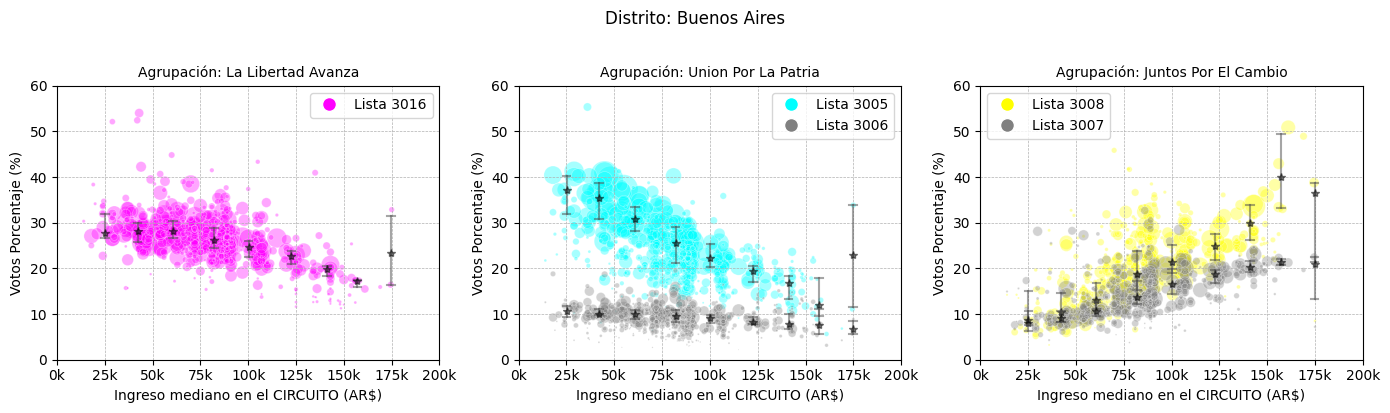

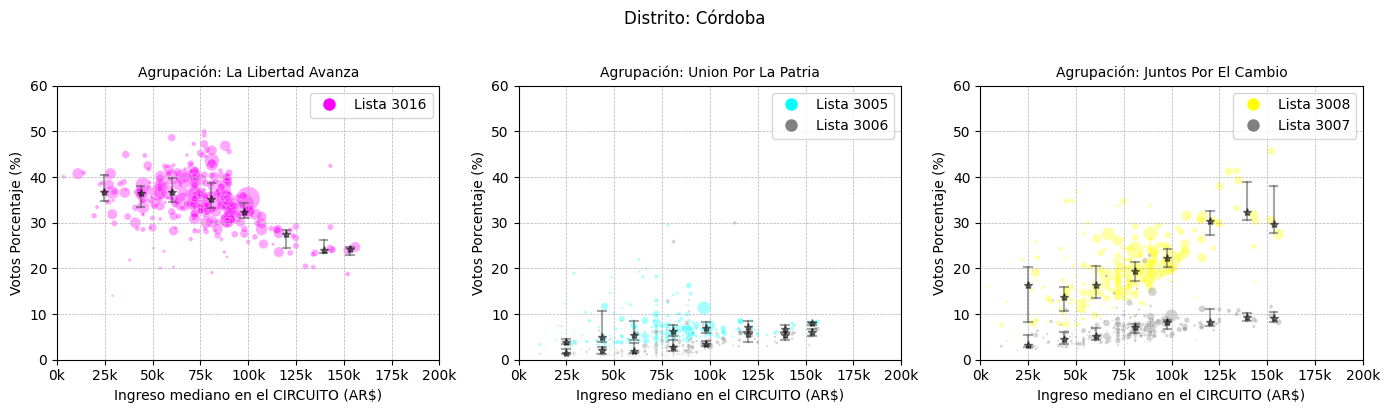

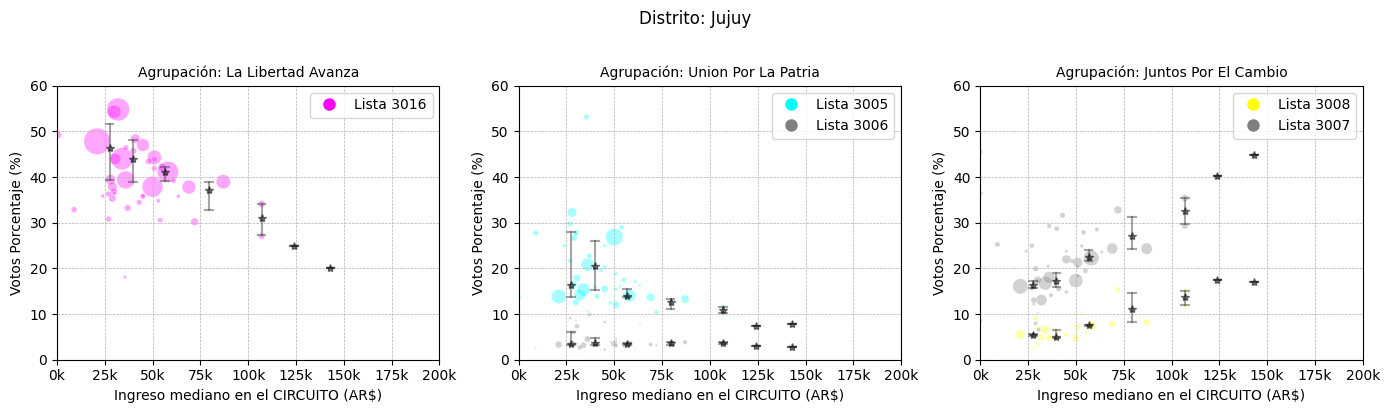

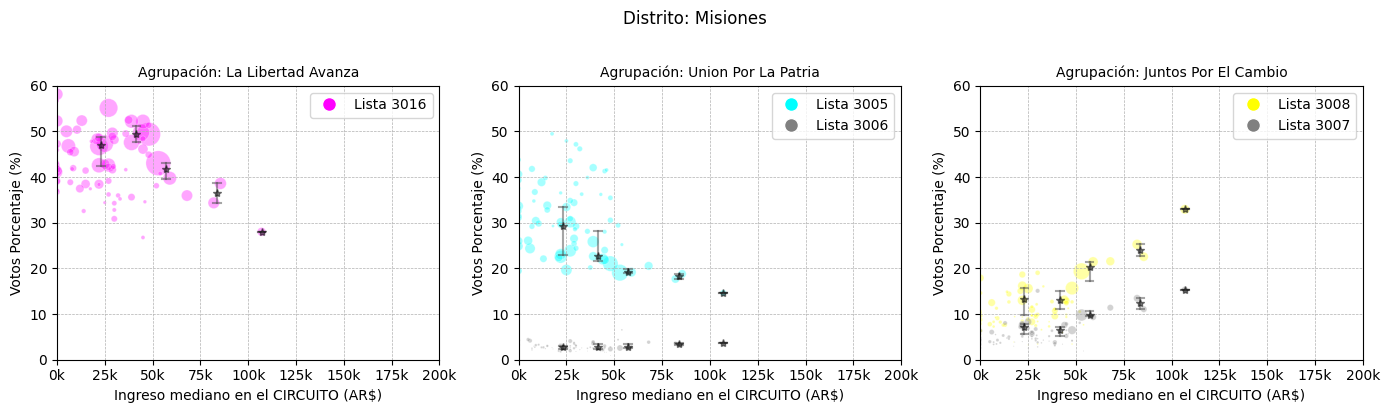

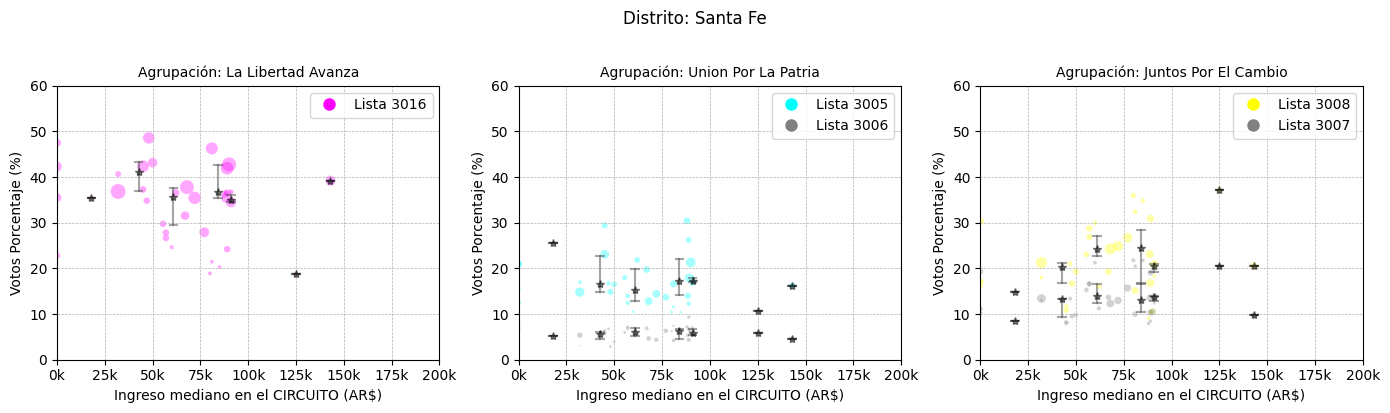

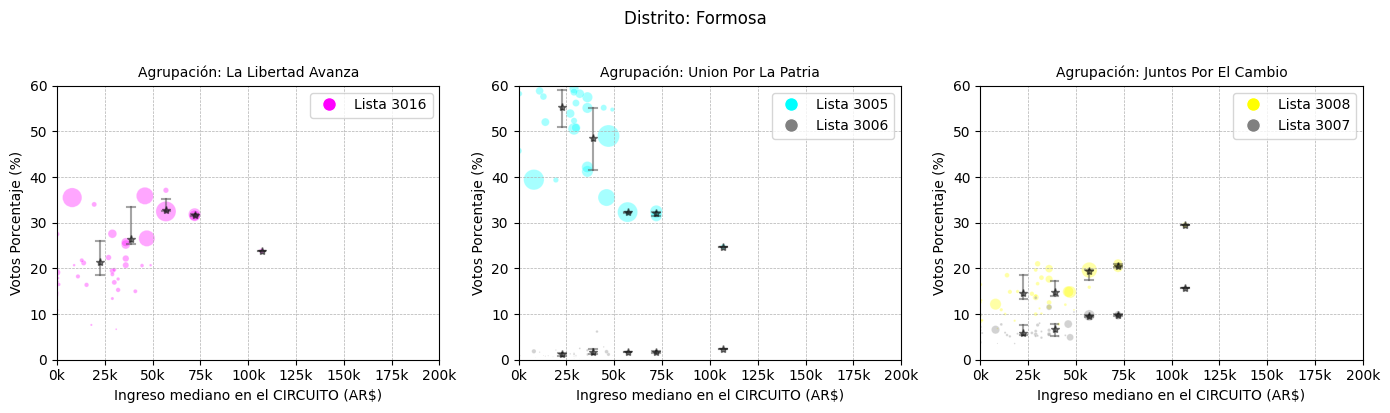

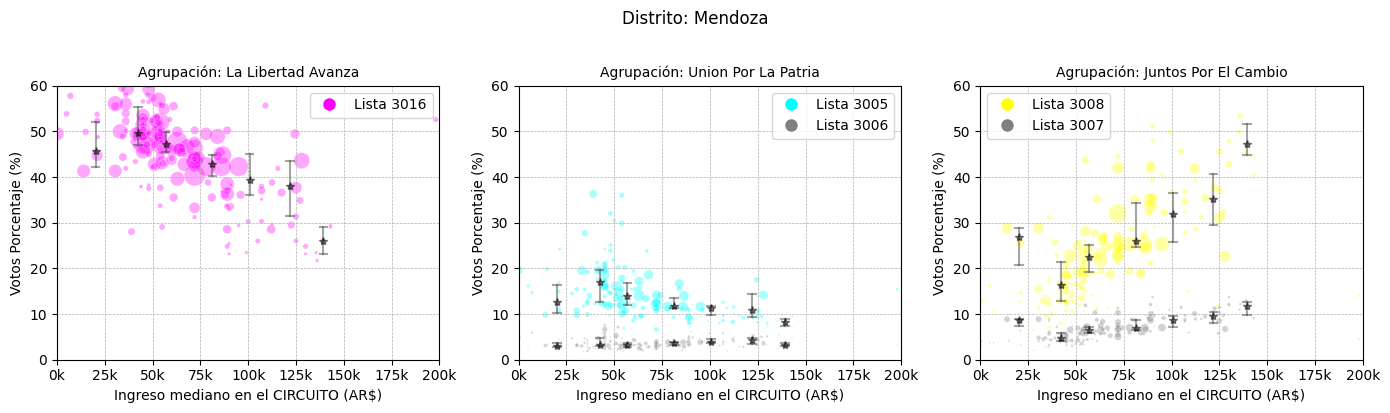

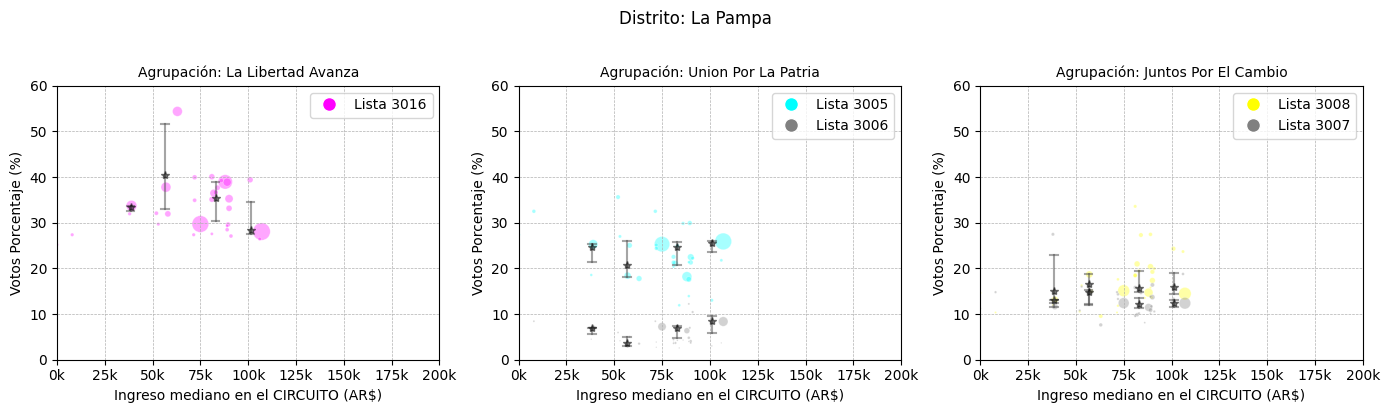

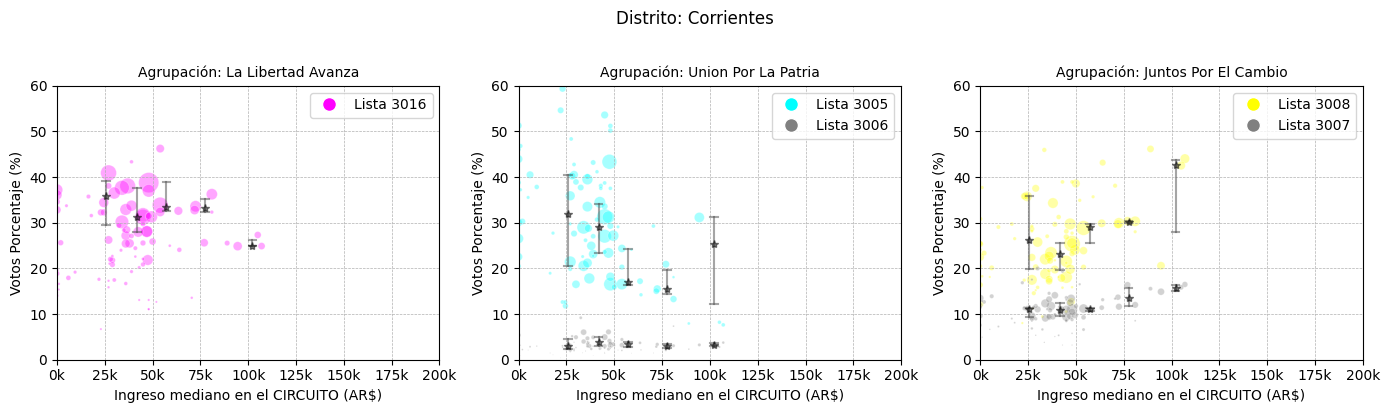

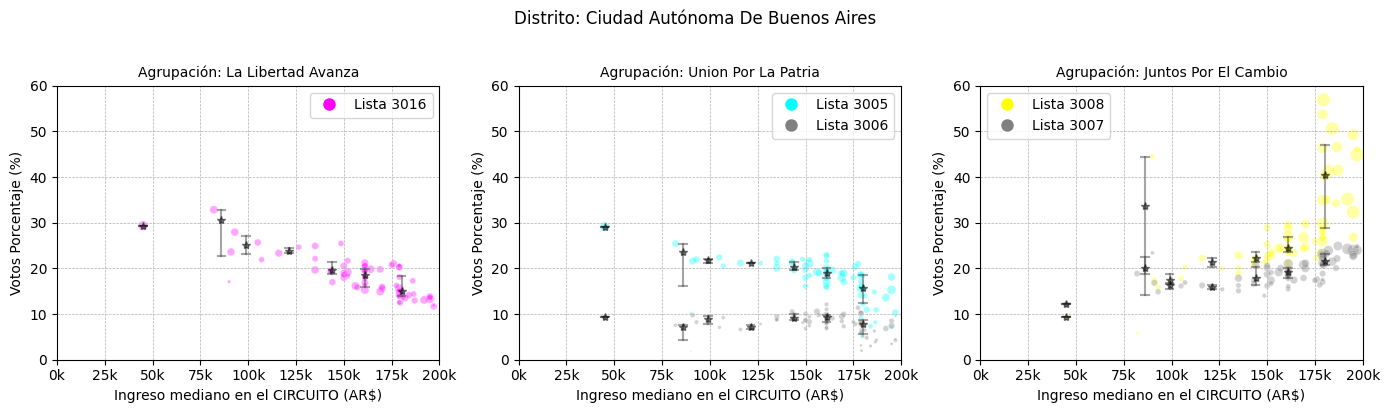

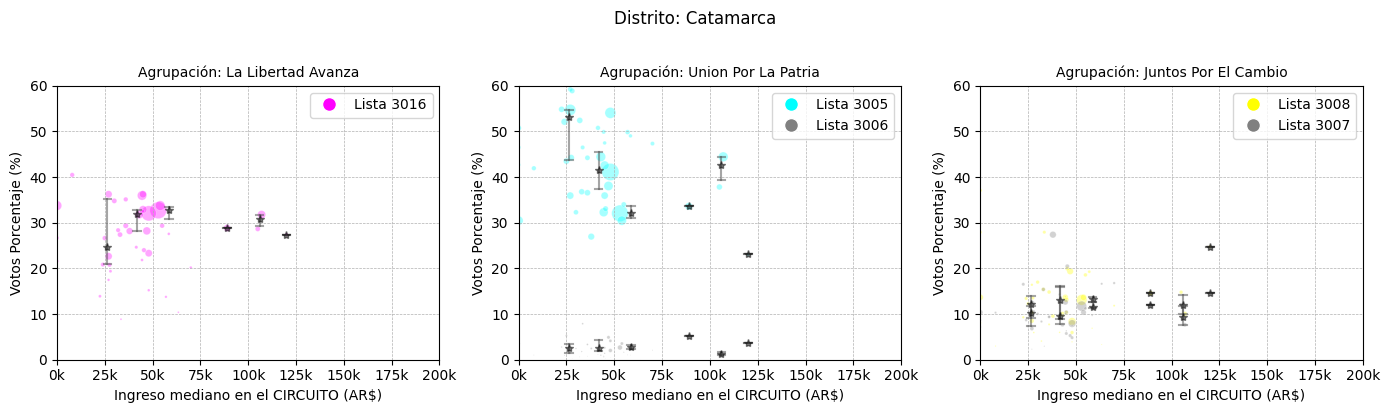

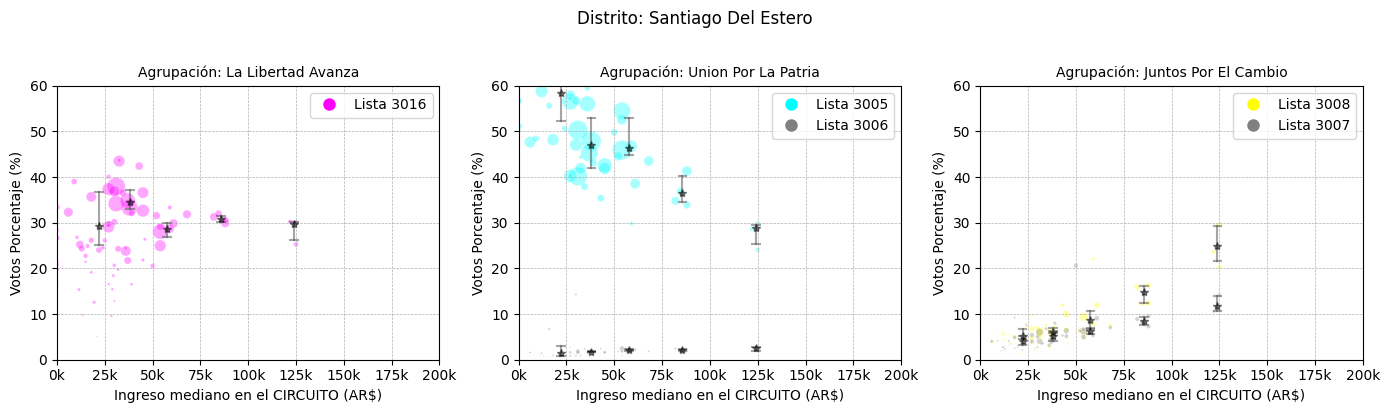

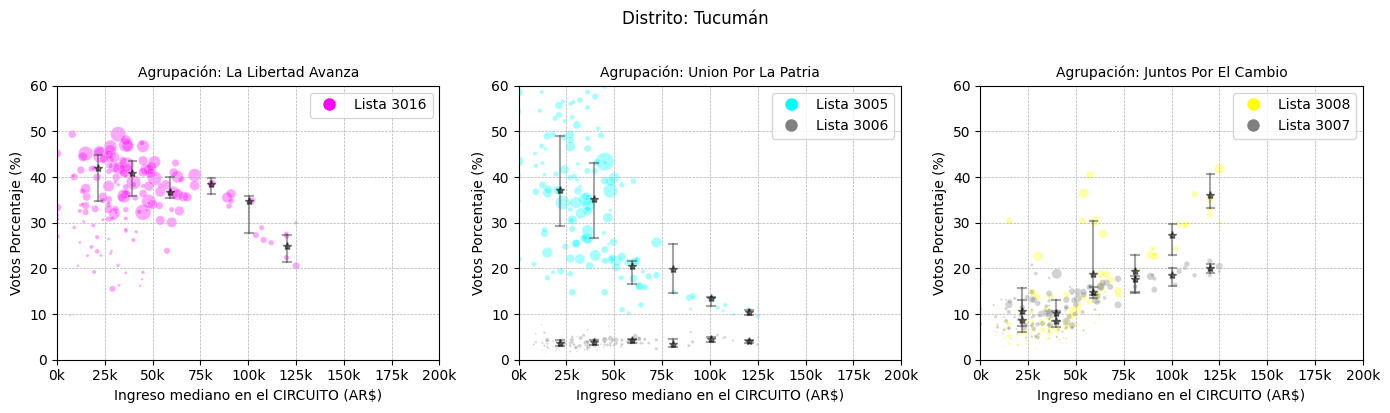

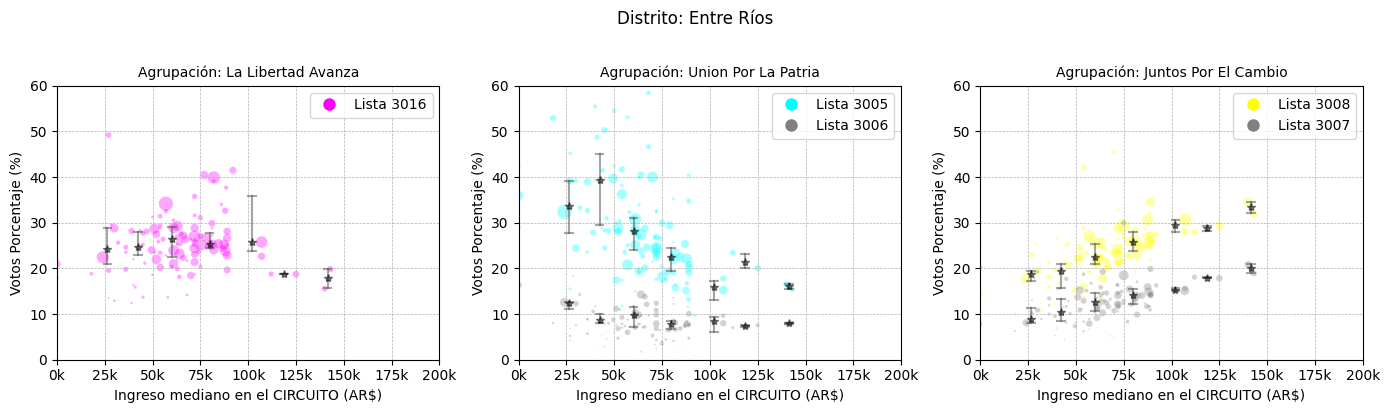

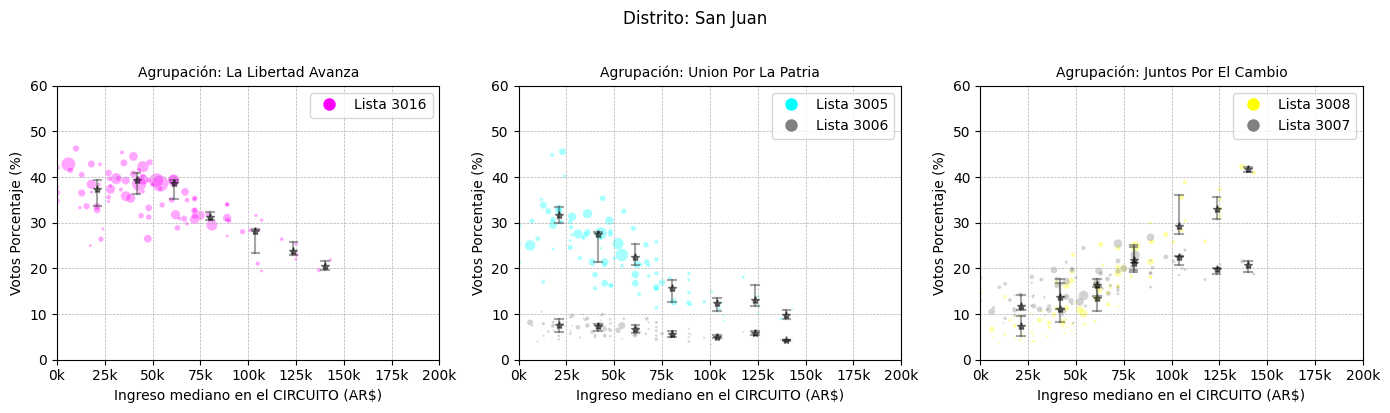

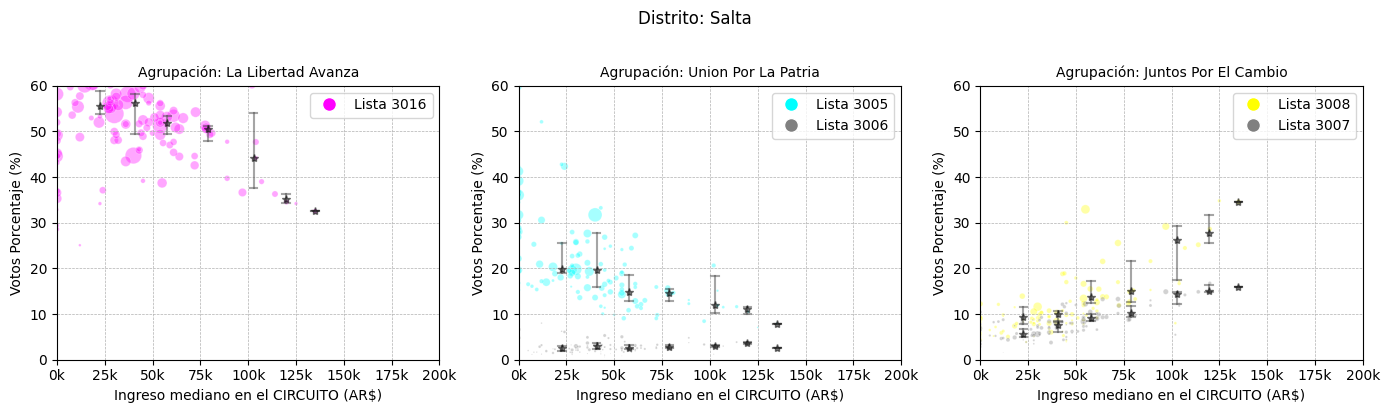

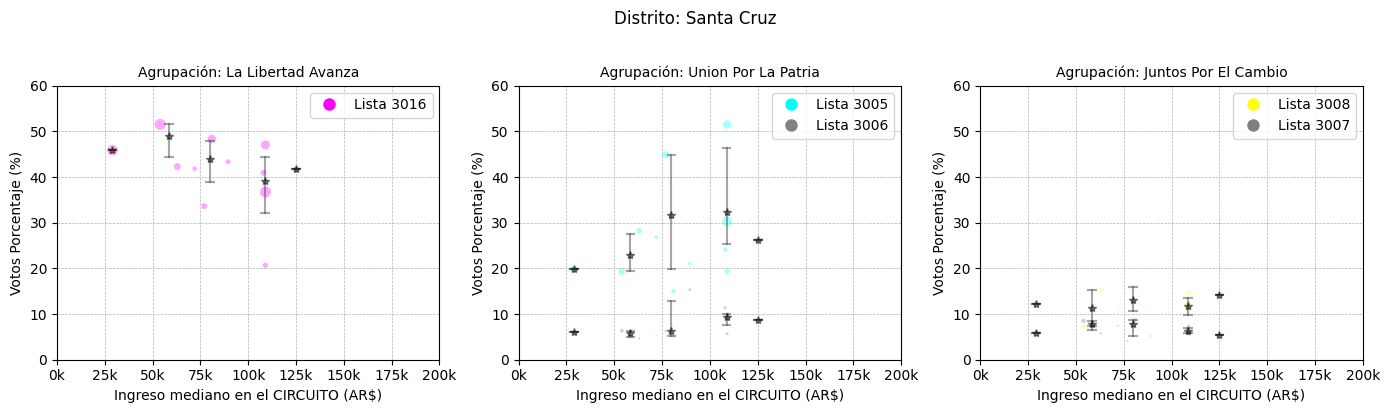

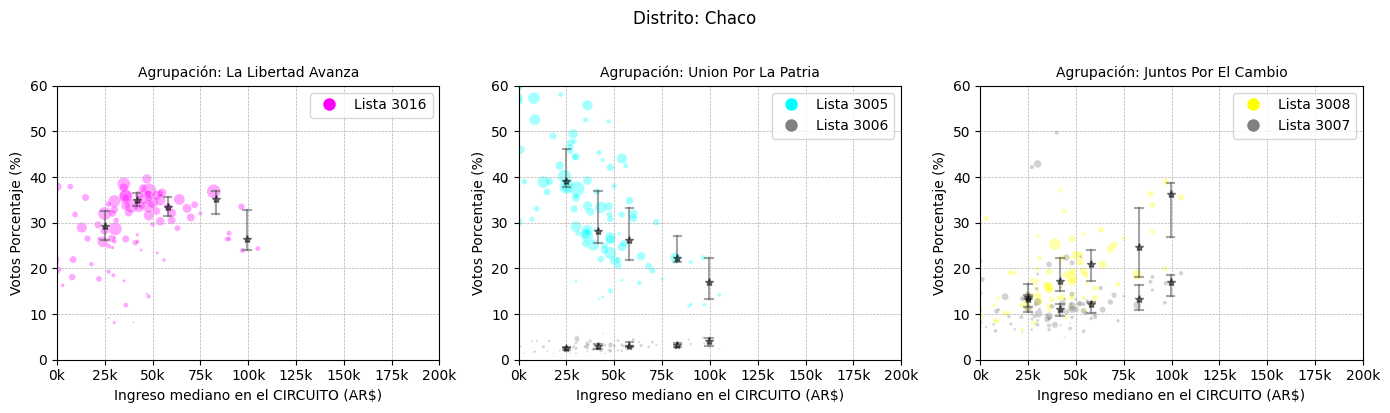

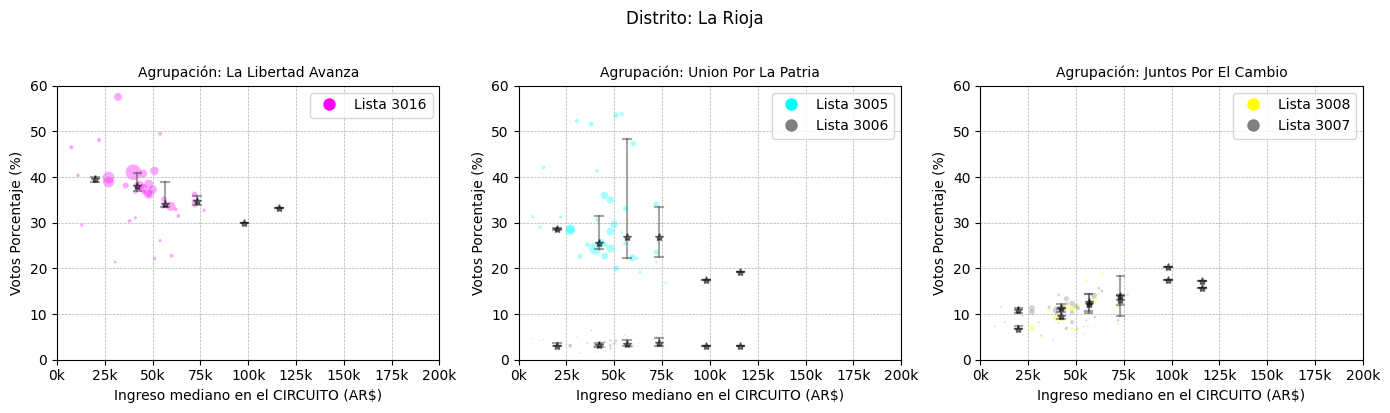

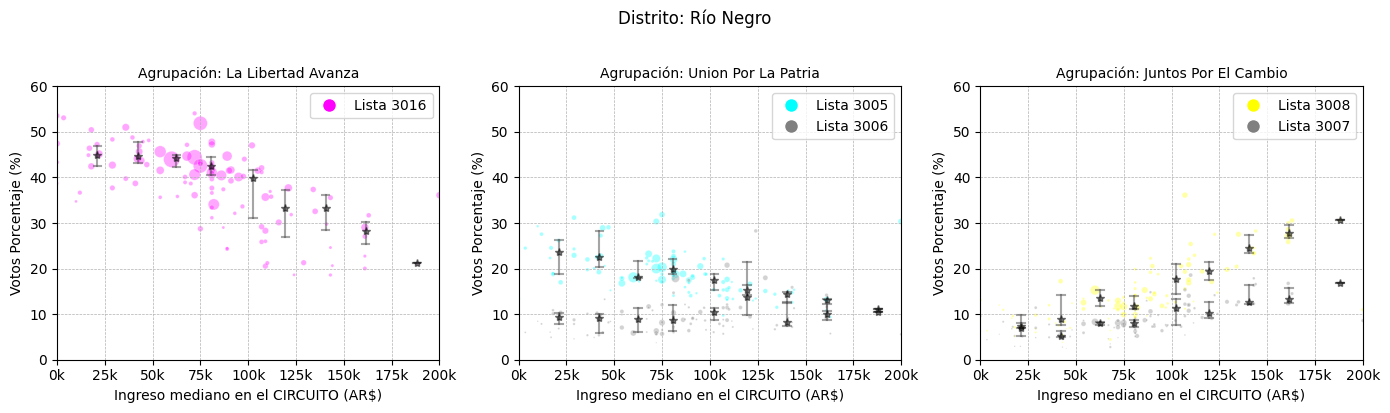

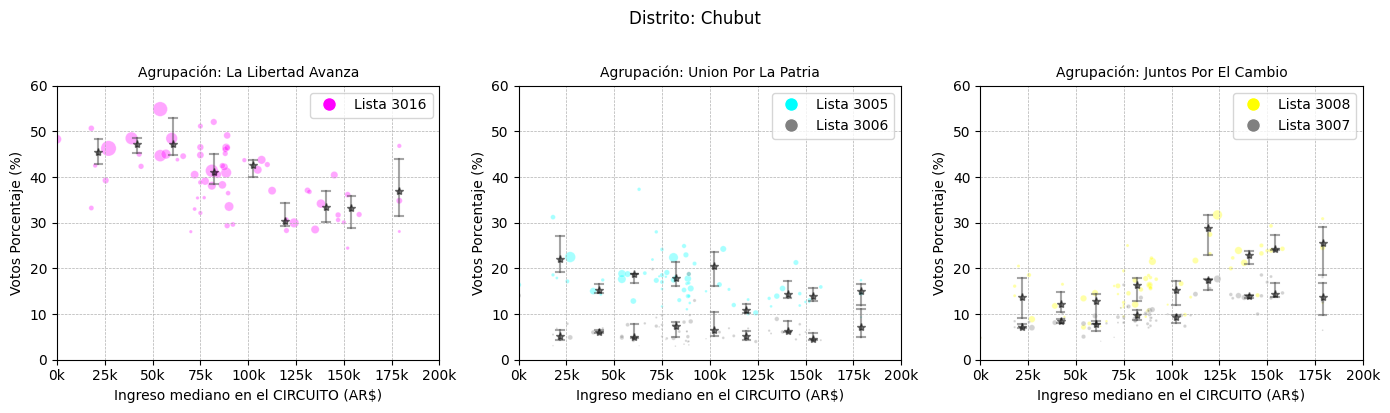

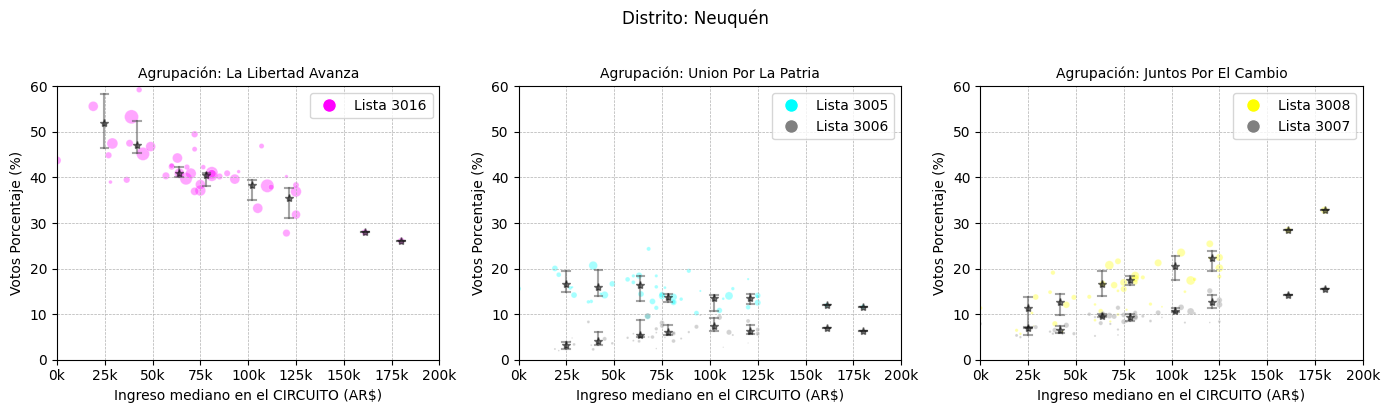

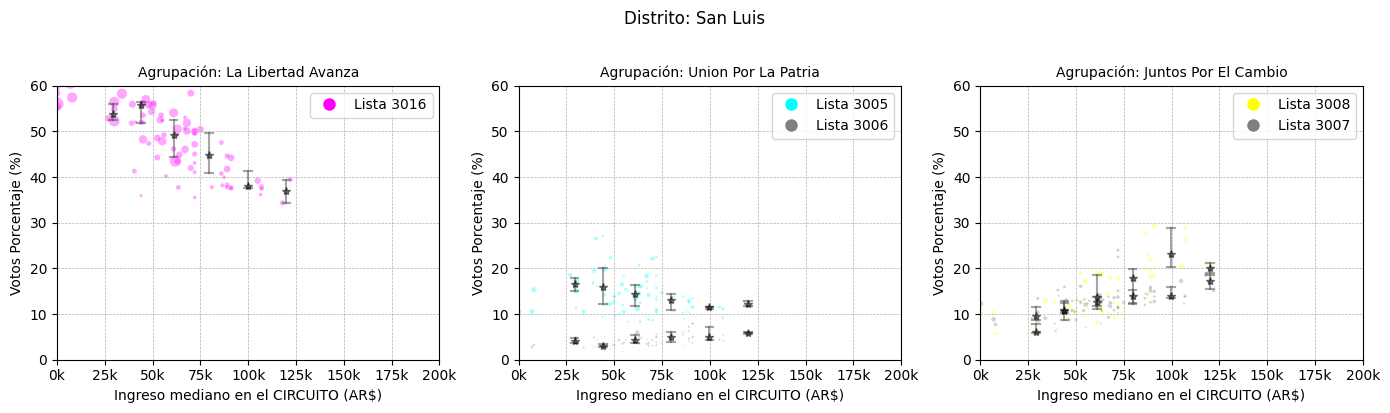

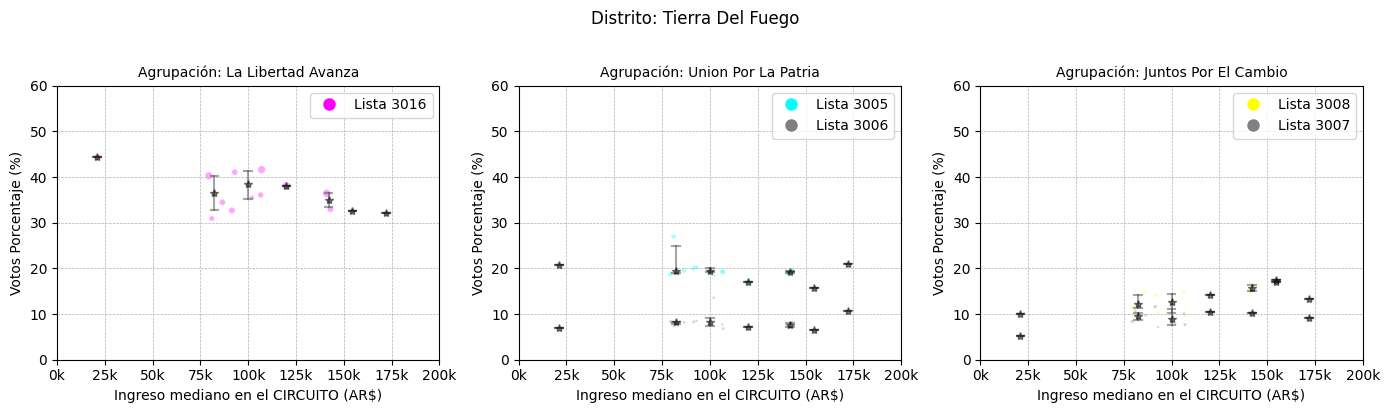

In [ ]:
# Extract unique distrito_id and corresponding distrito_nombre pairs
unique_distritos = info.drop_duplicates(subset=['distrito_id', 'distrito_nombre'])[['distrito_id', 'distrito_nombre']]

# Loop over each unique distrito_id and its corresponding distrito_nombre
for _, distrito_row in unique_distritos.iterrows():
    distrito_id = distrito_row['distrito_id']
    distrito_nombre = distrito_row['distrito_nombre']

    # Filter the data for the current distrito_id
    filtered_info = info[info['distrito_id'] == distrito_id]

    # Create a new figure with 1 row and 3 columns for the subplots
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))
    
    # Loop over each agrupacion within the filtered data
    for ax, agrupacion in zip(axs, main_listas['agrupacion_nombre_'].unique()):
        if agrupacion in colors_dict:
            rows_for_agrupacion = main_listas[main_listas['agrupacion_nombre_'] == agrupacion]
            
            legend_elements = []  # To collect legend handles and labels
            for idx, row in enumerate(rows_for_agrupacion.iterrows()):
                _, row = row
                should_shade = idx == 1
                plot_weighted_box(fig, ax, filtered_info, row['votos_tipo'], agrupacion, row['lista_numero'], ingreso_medio, bins=np.arange(10000, 200000, 20000))
                
                scatter_plot = plot_scatter(fig, ax, filtered_info, row['votos_tipo'], agrupacion, row['lista_numero'], ingreso_medio, colors_dict, shade=should_shade, alpha = .35)
                color = 'gray' if should_shade else colors_dict.get(agrupacion, 'black')
                legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f"Lista {row['lista_numero']}"))

            # Add legend to ax after all plots are drawn
            ax.legend(handles=legend_elements)


     # Set super title for the region
    plt.suptitle(f"Distrito: {distrito_nombre}", y=1.02)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save each region's figure separately
    plt.savefig(f'images/votos_vs_ingresosPASO23_distrito_{distrito_nombre}.jpg', bbox_inches='tight')  # Adding bbox_inches ensures everything is captured)
    plt.show()


In [ ]:
# for index, row in main_listas.iterrows():
#     # Check if the agrupacion_nombre_ has a color defined in colors_dict
#     # if row['agrupacion_nombre_'] in colors_dict:
#     # Create a new figure for each iteration
#     fig, axs = plt.subplots(1, 1, figsize=(6, 5))

#     plot_scatter(fig, axs, info, row['votos_tipo'], row['agrupacion_nombre_'], row['lista_numero'], ingreso_medio, colors_dict)
#     plot_weighted_box(fig, axs, info, row['votos_tipo'], row['agrupacion_nombre_'], row['lista_numero'], ingreso_medio)

#     plt.tight_layout()
#     plt.show()

In [ ]:
info

votos_tipo                              agrupacion_nombre_  \
0       POSITIVO                              La Libertad Avanza   
1       POSITIVO                              La Libertad Avanza   
2       POSITIVO                              La Libertad Avanza   
3       POSITIVO                              La Libertad Avanza   
4       POSITIVO                              La Libertad Avanza   
...          ...                                             ...   
23995   POSITIVO  Frente De Izquierda Y De Trabajadores - Unidad   
23996   POSITIVO  Frente De Izquierda Y De Trabajadores - Unidad   
23997   POSITIVO  Frente De Izquierda Y De Trabajadores - Unidad   
23998   POSITIVO  Frente De Izquierda Y De Trabajadores - Unidad   
23999   POSITIVO  Frente De Izquierda Y De Trabajadores - Unidad   

       lista_numero  distrito_id  seccion_id circuito_id  eleccion_id  \
0              3016            2          77      00652A           17   
1              3016            2          61      00635B           17   
2              3016            2          80      000665           17   
3              3016            2          38      000302           17   
4              3016            2          61      000635           17   
...             ...          ...         ...         ...          ...   
23995          3009            2         107      000907           17   
23996          3009           22          12      000103           17   
23997          3009            7          14      00084A           17   
23998          3009            8           9      000164           17   
23999          3009            4          26      000402           17   

       cargo_id  votos_cantidad   año eleccion_tipo recuento_tipo padron_tipo  \
0             1           22969  2023          PASO    PROVISORIO      NORMAL   
1             1           17119  2023          PASO    PROVISORIO      NORMAL   
2             1           17272  2023          PASO    PROVISORIO      NORMAL   
3             1           17723  2023          PASO    PROVISORIO      NORMAL   
4             1           15525  2023          PASO    PROVISORIO      NORMAL   
...         ...             ...   ...           ...           ...         ...   
23995         1              13  2023          PASO    PROVISORIO      NORMAL   
23996         1               5  2023          PASO    PROVISORIO      NORMAL   
23997         1               3  2023          PASO    PROVISORIO      NORMAL   
23998         1               4  2023          PASO    PROVISORIO      NORMAL   
23999         1               3  2023          PASO    PROVISORIO      NORMAL   

      eleccion_tag cargo_nombre cargo_tag  votos_porcentaje  
0          PASO23n   Presidente        PR          0.281469  
1          PASO23n   Presidente        PR          0.254014  
2          PASO23n   Presidente        PR          0.251885  
3          PASO23n   Presidente        PR          0.267267  
4          PASO23n   Presidente        PR          0.256662  
...            ...          ...       ...               ...  
23995      PASO23n   Presidente        PR          0.014525  
23996      PASO23n   Presidente        PR          0.005133  
23997      PASO23n   Presidente        PR          0.003122  
23998      PASO23n   Presidente        PR          0.004206  
23999      PASO23n   Presidente        PR          0.003058  

[24000 rows x 17 columns]

In [ ]:
xx

In [ ]:
import pandas as pd

import math

def harmonize_agrupacion_id(agrupacion_id):
    if pd.isna(agrupacion_id):
        return "000000"
    else:
        try:
            # Attempt to convert string to float and then to integer
            return str(int(float(agrupacion_id))).zfill(6)
        except ValueError:
            # If conversion fails, return original string value
            return agrupacion_id

In [ ]:
# Read the CSV file into a DataFrame
df = pd.read_csv('./../datos/BD/votos_eleccion_17_table.csv') 


# Filter the DataFrame using loc and the condition (for example, where 'cargo_id' is 1 or 3)
df = df.loc[df['cargo_id'].isin([1, 3])]
data = df
data['agrupacion_id'] = data['agrupacion_id'].apply(harmonize_agrupacion_id)

/tmp/ipykernel_186561/1967422595.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./../datos/BD/votos_eleccion_17_table.csv')


In [ ]:
cargo = pd.read_csv('./../datos/BD/cargo_table.csv')

agrup_lista = pd.read_csv('./../datos/BD/agrupacion_lista_table.csv')
agrup_lista['agrupacion_id'] = agrup_lista['agrupacion_id'].apply(harmonize_agrupacion_id)
agrup_lista['lista_numero'] = agrup_lista['lista_numero'].apply(harmonize_agrupacion_id)
agrup_lista


simil_nombre = agrup_lista.groupby(['eleccion_id', 'distrito_id', 'distrito_nombre', 'agrupacion_id']).agrupacion_nombre.first().reset_index()

merged_data = data.merge(simil_nombre)

In [ ]:

merged_data['agrupacion_nombre'] = merged_data['agrupacion_nombre'].replace('CAMBIEMOS BUENOS AIRES', 'CAMBIEMOS')
merged_data['agrupacion_nombre'] = merged_data['agrupacion_nombre'].replace('JUNTOS', 'JUNTOS POR EL CAMBIO', regex=False)
merged_data['agrupacion_nombre'] = merged_data['agrupacion_nombre'].str.title()




In [ ]:
out = merged_data.groupby(['eleccion_id', 'cargo_id', 'agrupacion_nombre', 'lista_numero', 'votos_tipo'])[['votos_cantidad']].sum().reset_index()
out


eleccion_id  cargo_id                               agrupacion_nombre  \
0             17         1  Frente De Izquierda Y De Trabajadores - Unidad   
1             17         1  Frente De Izquierda Y De Trabajadores - Unidad   
2             17         1                                 Frente Liber.Ar   
3             17         1                                 Frente Liber.Ar   
4             17         1                                 Frente Liber.Ar   
..           ...       ...                                             ...   
230           17         3                             Union Por La Patria   
231           17         3                              Union Por San Luis   
232           17         3             Unite Por La Libertad Y La Dignidad   
233           17         3             Unite Por La Libertad Y La Dignidad   
234           17         3                                Unión Y Libertad   

     lista_numero votos_tipo  votos_cantidad  
0            3009   POSITIVO          442085  
1            3010   POSITIVO          186808  
2            3002   POSITIVO            8281  
3            3003   POSITIVO           13109  
4            3004   POSITIVO            5572  
..            ...        ...             ...  
230          3325   POSITIVO          295149  
231          3125   POSITIVO           46949  
232          3121   POSITIVO            1157  
233          3142   POSITIVO             961  
234          3197   POSITIVO            6553  

[235 rows x 6 columns]

In [ ]:
n = 6
main = out.groupby(['eleccion_id', 'cargo_id', 'votos_tipo']).apply(lambda x: x.nlargest(n, 'votos_cantidad')).reset_index(drop=True).rename(columns={'votos_cantidad': 'votos_nacional'})
main


eleccion_id  cargo_id         agrupacion_nombre  lista_numero votos_tipo  \
0            17         1        La Libertad Avanza          3016   POSITIVO   
1            17         1       Union Por La Patria          3005   POSITIVO   
2            17         1      Juntos Por El Cambio          3008   POSITIVO   
3            17         1      Juntos Por El Cambio          3007   POSITIVO   
4            17         1       Union Por La Patria          3006   POSITIVO   
5            17         1  Hacemos Por Nuestro Pais          3001   POSITIVO   
6            17         3       Union Por La Patria          3005   POSITIVO   
7            17         3        La Libertad Avanza          3016   POSITIVO   
8            17         3      Juntos Por El Cambio          3008   POSITIVO   
9            17         3      Juntos Por El Cambio          3007   POSITIVO   
10           17         3        La Libertad Avanza          3316   POSITIVO   
11           17         3  Hacemos Por Nuestro País          3181   POSITIVO   

    votos_nacional  
0          7116352  
1          5070104  
2          4022466  
3          2675563  
4          1390585  
5           907437  
6          3797584  
7          2968100  
8          2461554  
9          1958899  
10          825441  
11          548706

In [ ]:
data_copy = data.copy()

In [ ]:
data_copy['agrupacion_nombre'] = data_copy['agrupacion_nombre'].replace('CAMBIEMOS BUENOS AIRES', 'CAMBIEMOS')
data_copy['agrupacion_nombre'] = data_copy['agrupacion_nombre'].replace('JUNTOS', 'JUNTOS POR EL CAMBIO')
data_copy['agrupacion_nombre'] = data_copy['agrupacion_nombre'].str.title()



data_copy = data_copy.merge(main, how = 'left')

## Limpiar

data_copy['agrupacion_nombre'] = data_copy['agrupacion_nombre'].str.title().str.strip()

data_copy['agrupacion_nombre_'] = data_copy['agrupacion_nombre'].mask(data_copy['votos_nacional'].isnull()).fillna('Resto')

data_aggregated = data_copy.groupby(['distrito_id', 'distrito_nombre', 'seccion_id', 'circuito_id', 'mesa_id', 'cargo_id', 'agrupacion_nombre_', 'votos_tipo', 'eleccion_id'])['votos_cantidad'].sum()
data_aggregated = data_aggregated.reset_index()

In [ ]:
## Seccion_id no es necesario, alcanza con provincia-circuito. Pero lo agregamos porque a traves de los circuitos se relaciona el seccion_id con el id de deptos en IGN.
data_circ = data_aggregated.groupby(['eleccion_id', 'cargo_id', 'agrupacion_nombre_', 'votos_tipo', 'distrito_id', 'distrito_nombre', 'seccion_id', 'circuito_id'])[['votos_cantidad']].sum()
# data_circ.to_csv('./../datos/out/votos_agrup_circ.csv')
data_circ.groupby('cargo_id').votos_cantidad.sum()

cargo_id
1    24016776
3    23502142
Name: votos_cantidad, dtype: int64

In [ ]:
claves_dptos = pd.read_csv('./../datos/BD/claves_dptos_ref.csv')
claves_dptos = claves_dptos.loc[~claves_dptos.codprov.isna()].astype({'codprov': 'Int64', 'coddepto' : 'Int64', 'IN1' : 'Int64'})
claves_dptos['codprov'] = claves_dptos['codprov'].astype(str).str.zfill(2)
claves_dptos['coddepto'] = claves_dptos['coddepto'].astype(str).str.zfill(3)
claves_dptos['IN1'] = claves_dptos['IN1'].astype(str).str.zfill(5)
claves_dptos.loc[(claves_dptos.seccion_nombre == 'La Plata'), 'IN1'] = '06441'
claves_dptos.head()

prov_ids = claves_dptos.copy()
prov_ids['in1_prov'] = prov_ids['IN1'].astype(str).str[:2]
prov_ids = prov_ids[['distrito_id', 'distrito_nombre', 'in1_prov']].drop_duplicates().reset_index(drop=True)

# prov_ids = pd.read_csv('./../datos/info/radio_ref.csv')[['PROV_REF_ID', 'IDPROV']].drop_duplicates().rename(columns = {'IDPROV': 'in1_prov', 'PROV_REF_ID': 'distrito_id'}).reset_index(drop = True)
# prov_ids['in1_prov'] = prov_ids['in1_prov'].astype(str).str.zfill(2)
# prov_ids.head()

eleccion_tags = pd.read_csv('./../datos/BD/eleccion_tags.csv')


In [ ]:
# data_circ = pd.read_csv('./../datos/out/votos_circ.csv').merge(prov_ids)
data_circ = pd.read_csv('./../datos/out/votos_agrup_circ.csv').merge(prov_ids)
# data_circ['agrupacion_nombre_'] = data_circ['agrupacion_nombre_'].fillna('NO POSITIVOS')

# Guardar ref provs - dptos - circs
dist_secc_circ = data_circ.copy() # save for later

# data_circ
data_circ = data_circ.merge(eleccion_tags).merge(cargo)


# Group by 'eleccion_tag', 'cargo_tag', and 'in1_prov', and calculate the sum of 'votos_cantidad', divide for PCT
sum_votes = data_circ.groupby(['eleccion_tag', 'cargo_tag', 'in1_prov', 'votos_tipo', 'circuito_id'])['votos_cantidad'].transform('sum')
data_circ['votos_porcentaje'] = data_circ['votos_cantidad'] / sum_votes


data_circ = data_circ.set_index(['distrito_id', 'distrito_nombre', 'circuito_id', 'eleccion_tag', 'cargo_tag', 'agrupacion_nombre_', 'votos_tipo'])


data_circ_table_cnt = data_circ['votos_cantidad'].unstack(['eleccion_tag', 'cargo_tag', 'votos_tipo', 'agrupacion_nombre_'])
data_circ_table_pct = data_circ['votos_porcentaje'].unstack(['eleccion_tag', 'cargo_tag', 'votos_tipo', 'agrupacion_nombre_'])


In [ ]:

data_circ_geoms_cnt.to_file('./../datos/geojson/votos_cnt_circ.geojson', driver='GeoJSON') # Save the GeoDataFrame to GeoJSON
data_circ_geoms_pct.to_file('./../datos/geojson/votos_pct_circ.geojson', driver='GeoJSON') # Save the GeoDataFrame to GeoJSON


data_circ_geoms_cnt.to_file('./../datos/geojson/votos_cnt_circ.geojson', driver='GeoJSON') # Save the GeoDataFrame to GeoJSON
data_circ_geoms_pct.to_file('./../datos/geojson/votos_pct_circ.geojson', driver='GeoJSON') # Save the GeoDataFrame to GeoJSON


data_circ_geoms_cnt.to_file('./../datos/geojson/votos_cnt_circ.geojson', driver='GeoJSON') # Save the GeoDataFrame to GeoJSON
data_circ_geoms_pct.to_file('./../datos/geojson/votos_pct_circ.geojson', driver='GeoJSON') # Save the GeoDataFrame to GeoJSON